In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a convolution?

In TF, each input image is typically represented as a 3D tensor of shape *[height, width, channels]*. A mini-batch is represented as a 4D tensor of shape *[mini-batch. height, width, channels]*.

The weights are represented as a 4D tensor of shape [*height of receptive field, width of receptive field, number of feature maps in previous layer, and bias terms*]

Breaking down the `tf.nn.conv2d`:
  - images is the input mini-batch (4D tensor)
  - filters is the set of filter (4D tensor)
  - strides, is equal to one but also takes a 1D array with 4 elements, where the two middle elements arethe vertical and horizontal stride, first and last must be 1's.
  - padding:
    "SAME": The conv layer will use zero padding if necessary. Output size is set to the number of input neurons divided by the stride, rounded up. Then zeros are added as evenly as possible around the inputs. When strides=1, the layers outputs will have the same width and height as its inputs, hence "SAME".
    "VALID": Does not use zero padding and may ignore some rows and cols to the bottom and right, depending on the stride. Every neuron's receptive field only lies with valid positions, hence the name.

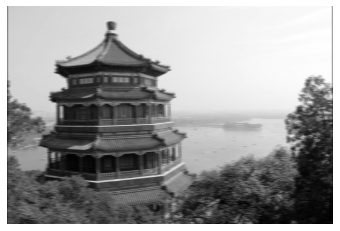

In [10]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, 
                       padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") #plot 1st image's 2nd feature map
plt.axis("off") #not shown in the book
plt.show()

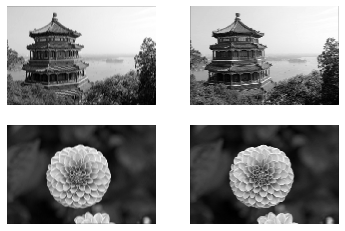

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index
                   + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

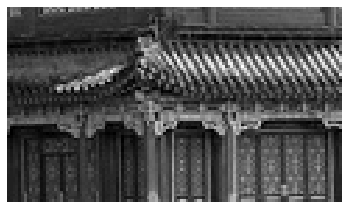

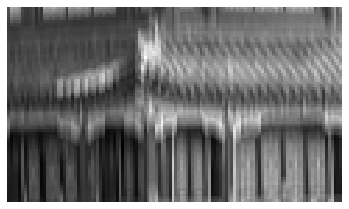

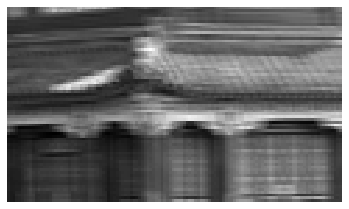

In [7]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical",
                                             "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

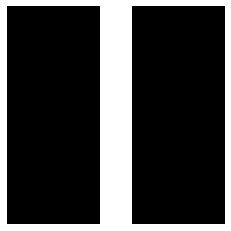

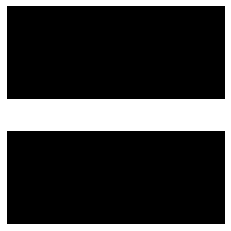

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()

plot_image(filters[:, :, 0, 1])
plt.show()

### Memory Requirements

CNN's are RAM intensive. During inference, the RAM of one layer can be released as soon as the next layer has been computed, so you only need two layers worth of RAM. **During training**, eveerything computed for the forward pass needs to be saved for the reverse pass, so it needs the amount of RAM of all layers.

Some things to try if getting memory crashes: reducing batch mini-size, reducing dimensionality with a stride, remove layers, convert 32bit floats to 16bit, or distribute the CNN across multiple devices.


## Pooling Layers

Their goal is to subsample or shrink the image to reduce computational load, memory usage, and number of parameters.

Pooling layer is connected to the outputs of a limited number of neurons in the previous layer, like conv layers. It has no weights, all it does is aggregate inputs with a function like max or mean. 

Stateless sliding windows when describing *pooling kernel*. 

*Max pooling layer* introduces some invariance to small differences in where th sliding window is (to translation of the window). This is good so the model isn't getting bogged down by details. However, this is destructive, it can remove a lot of input values.

The opposite of invariance is equivarience, in which a small change of the input leads to the same small change in outputs.

In [11]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [12]:
cropped_images = np.array([crop(image) for image in images],
                          dtype=np.float32)
output = max_pool(cropped_images)

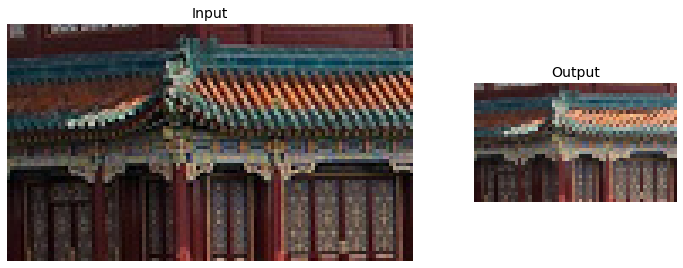

In [16]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) #plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0]) #plot output for 1st image
ax2.axis("off")
plt.show()

### Depth-wise pooling

Generally, MaxPool is better than AvgPool because MaxPool only looks at the strongest features, has stronger translation invariance, cleaner signal, and slighlty less to compute. 

Pooling can also be done along the depth dimension rather than the spatial one, used uncommonly. Can help with being invariant to various features.

TF has a function that will can this. `tf.nn.max_pool`. The first three values of kernel size and strides should be one, that is, kernel size along batch, height, and width are 1. The last value will be across the depth dimension and it must be a divisor of the input depth or it wont work.

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID",
                **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize=(1,1,1,self.pool_size),
                             strides=(1,1,1,self.pool_size),
                             padding=self.padding)

In [20]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [21]:
# Using it as a Keras layer
# wrap it in a Lambda layer

depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X,
                            ksize=(1,1,1,3),
                            strides=(1,1,1,3),
                            padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

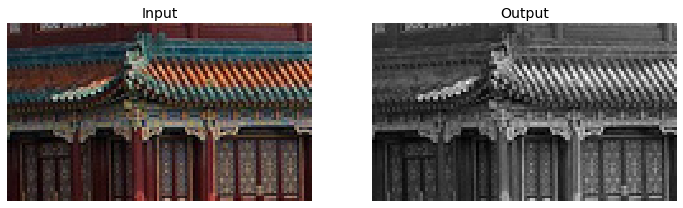

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1,2,2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

### Average Pooling

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [24]:
output_avg = avg_pool(cropped_images)

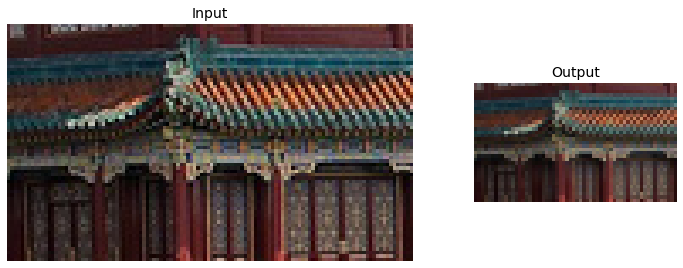

In [25]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) 
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

### Global Average Pooling

This is different from average pooling. It computes the mean of each entire feature map. It will output one number per feature map and per instance, which is highly destructive, but it is used successfully as an output layer in many architectures. 


In [26]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [27]:
output_global_avg2 = keras.layers.Lambda(lambda X:tf.reduce_mean(X, axis=[1,2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## CNN Architectures

Typically they go, conv layer, ReLu, Pooling, conv layers + Relu, pooling, then a feedforward neural network, and a final output layer like softmax if its classification.

Common mistake: using convolution kernels that are too large. Instead of a 5 x 5, use two 3 x 3, less parameters, less to compute. Exception is the first Conv layer can have a large kernel with a stride of 2 or more.

In [28]:
(X_train_full, y_train_full),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

#np.newaxis creates a new axis and is equal to None
X_train = X_train[...,np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [29]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

#### Breakdown of above model:

First conv layers use 64 large filers (7 x 7) but no stride b/c input images aren't large. Input shape is [28, 28, 1], b/c input images are 28 x 28 and there is one color channel, greyscale.

Maxpooling has pool size of 2 so it divides each spatial dim by factor of 2.

Repeat the same structure twice, for larger images, can do this repetition more times. (Tunable in the sense that its by experiment to find the best structure)

The number of filters is growing in amount. Makes sense because you can combine the low-level featues like circles and whatevrs into more complex high-level features. Also common practice to double filters after every pooling layer, since we made it smaller with the pooling, dont have to worry about exploding the computational load. 

Last is fully connectd network, have to flatten the inputs first since dense networks expect 1D arrays, and also add dropout to avoid overfitting.




In [ ]:
'''#stopped training because its hella slow

model.compile(loss='sparse_categorical_crossentropy',
             optimizer="nadam",
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10] #pretend these are new images
y_pred= model.predict(X_new)'''

#### Some CNN architecture history:

AlexNet introduced *local response normalization* which in like biological neurons, strongly activated neurons inhibit other neurons located in the same position in neighbouring feature maps. Encourages specialization.

GoogLeNet used *inception modules* to use parameters more efficiently and allowed it to go deeper than AlexNet. The diagram is very explanatory (pg 467).
(adding a lot more conv kernels hyperparameters to tweak with an inception module)

### ResNet-34

In [33]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3,
                       strides=1, padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation="relu",
                **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layer= [
            DefaultConv2D(filters,strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters,kernel_size=1,strides=strides),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layer:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [34]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64,kernel_size=7, strides=2,
                       input_shape=[224,224,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2,
                                padding="SAME"))
prev_filters = 64
# loop here just repeats 64 3 times, 128 4 times and so on
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Model

Can load some models with the weights, like ResNet-50. To use these, just got to make sure the input images are the correct size.

`tf.image.resize()` doesnt preserve the aspect ratio, if thats a problem can use tf.image.crop_and_resize().

102973440/102967424 [==============================] - 11s 0us/step


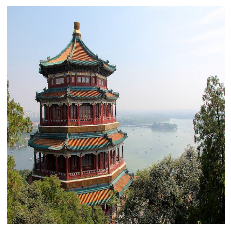

In [37]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

images_resized = tf.image.resize(images,[224,224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


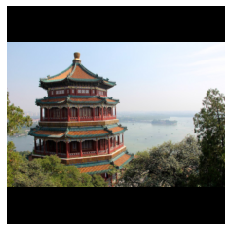

In [38]:
images_resized = tf.image.resize_with_pad(images, 224,224,antialias=True)
plot_color_image(images_resized[0])

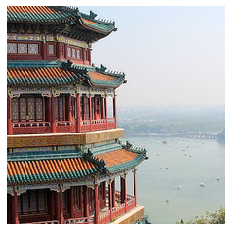

In [39]:
images_resized = tf.image.resize_with_crop_or_pad(images,224,224)
plot_color_image(images_resized[0])
plt.show()

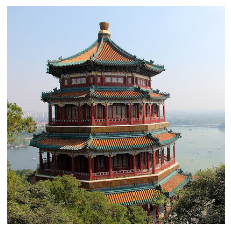

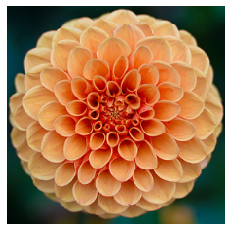

In [40]:
china_box = [0,0.03,1,0.68]
flower_box = [0.19,0.26,0.86,0.7]
images_resized = tf.image.crop_and_resize(images,[china_box, flower_box], 
                                         [0,1], [224,224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [41]:
#built in preprocessing function for model
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)


In [42]:
Y_proba.shape

(2, 1000)

In [43]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))
    print()    

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



The output Y_proba is a matriz with one row per image and one column per class. There are 1000 classes. `decode_predictions()` returns an array of the top K predictions, where each pred is an array with a class identifier, its name, and confidence score.

## Pretrained Models with Transfer Learning

Resuing lower layers.

In [44]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True,with_info=True)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /Users/misrakberhe/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [45]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [46]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [47]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [48]:
n_classes = info.features["label"].num_classes

In [49]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [51]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)


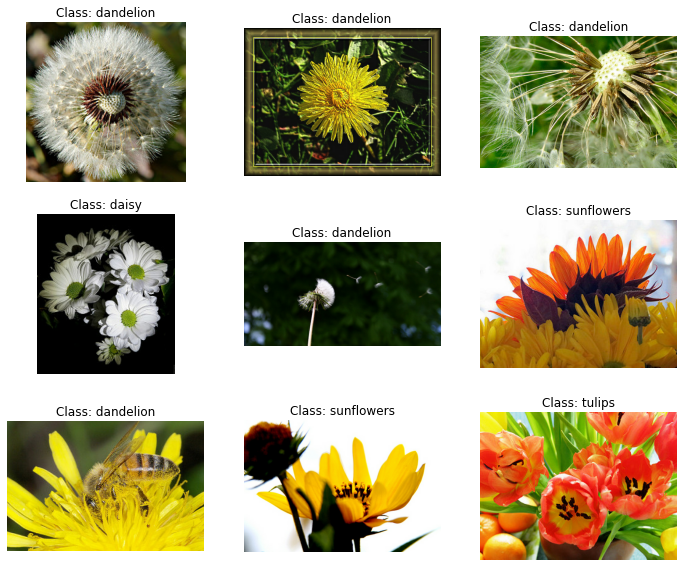

In [52]:
plt.figure(figsize=(12,10))
index=0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    
plt.show()

In [53]:
#BAsic Preprocessing
def preprocess(image,label):
    resized_image = tf.image.resize(image,[224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [56]:
#fancier preprocessing
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

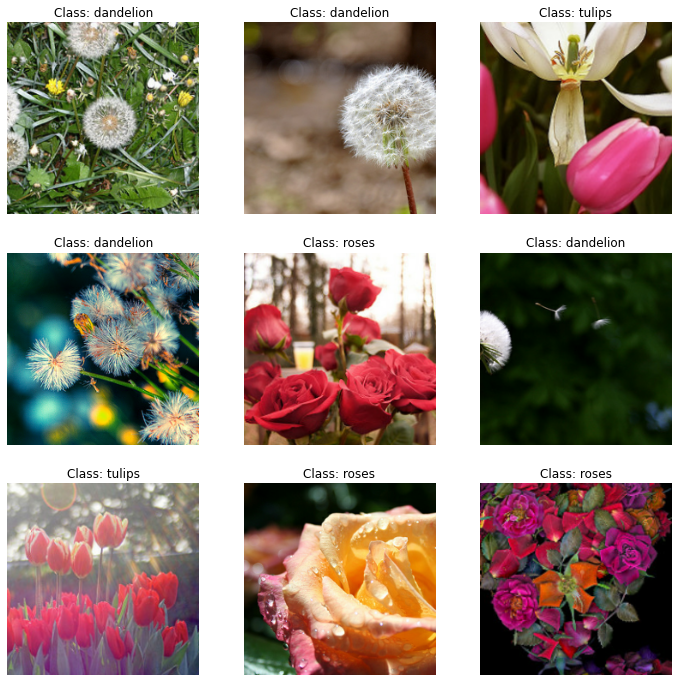

In [57]:
plt.figure(figsize=(12,12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3,3,index+1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

The `keras.preprocessing.image.ImageDataGenerator` class is good for tf.data pipelines. It can help augment and transform images after loading them, and also custom preprocessin with `tf.image` operations can be used in the pipeline as well as production.

In [61]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


In [62]:
for index, layer in enumerate(base_model.layers):
    print(index,layer.name)

0 input_5
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_56
13 block2_pool
14 batch_normalization_51
15 add_36
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_57
23 block3_pool
24 batch_normalization_52
25 add_37
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_58
33 block4_pool
34 batch_normalization_53
35 add_38
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_39
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [64]:
'''for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                   steps_per_epoch=int(0.75 * dataset_size / batch_size),
                   validation_data= valid_set,
                   validation_steps=int(0.15 * dataset_size / batch_size),
                   epochs=1)'''

86/86 [==============================] - 401s 5s/step - loss: 1.2474 - accuracy: 0.8176 - val_loss: 1.0805 - val_accuracy: 0.8346


Once the above is done, I can unfreeze all the layers or just the top ones and continue training using a lower learning rate. 

Suppper slow code block below, needs GPU love.

In [ ]:
'''for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=1)''' #40 epochs for 95%

## Classification and Localization

Localizing an object in a picture can be seen as a regression task, predictin the horizontal and vertical coordinates of the center along with its height and width. 4 numbers to predict.

Just need to add a second ouput to the above model.

A note about bounding boxes: the bounding box is the label, in this dataset there are no bounding boxes. The text talks about crowdsourcing and also just doing it yourself if its only a few thousand.

Got the bounding boxes, now need to create a dataset that has `(images, (class_labels, bounding_boxes))` as items.

MSE works well for training, but not really for evaluating the bounding boxes predicted. Commonly, the metric used is *Intersection over Union* (IoU): area of overlap between predicting bounding box and target bounding box, divided by the areas of their union. `tf.keras.metrics.MeanIoU` 

In [65]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [66]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [67]:
#too slow to run
#model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

### Mean Average Precision (mAP)

Looing at the precision-recall trade off, there is a a point when recall is super low, like 10%, that both recall and precision can both still go up. 

So what is done is getting maximum precision with 0% recall, and then 10 and 20% up to 100%. Calculating the mean of these precisions is the *Average Precision* and then if there are more than two classes, compute this for each class and then take  the mean which will be the **mAP**.

In [68]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

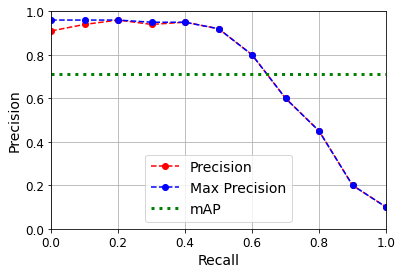

In [69]:
recalls = np.linspace(0,1 ,11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()

plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo--", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0,1], [mAP,mAP], "g:", linewidth = 3, label="mAP")
plt.grid(True)
plt.axis([0,1,0,1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

## Object Detection

The way it works it slides the window across the image, detecting the target objects. Sometimes multiple times.

Will need to get rid of the duplicate boxes, common approach is *non-max suppression*:
- Add an extra *objectness* output to the CNN(or a 'no-flower' class). This is to estimate the prob that a flower is actually in the image. Has to use sigmoid activation and train using binary cross-entropy loss. Then drop all bounding boxes below some threshold for objectness.
- Highest objectness scored bounding box, and get rid of overlapping ones (higher than 60% IoU score).

### Fully Convolutional Networks

Basically converting dense layers into conv layers. Can input any image size. Efficient because it only looks at the image once. 

Note: Going to have re-read this.

### You Only Look Once (YOLO)

Developed by Joseph Redmond, there is a YOLOv3. Can run in real time its so fast. It is a Fully Convolutional Network with some differences:
- Has 5 bounding boxes for each grid cell (instead of 1) and each box with its own objectness score. Outputs 20 class probs per grid cell. 45 numbers per cell. 5 BBoxes with 4 coordinates, + 5 objectness scores + 20 class probs.
- Instead of predicting the absolute coordinates of the BBoxes center, it predicts an offset relative to the coordinates of a grid cell. YOLOv3 only predicts BBoxes whose center lies in that grid cell.
- Before training, it uses the K-Means on the height and width of the training set BBoxes to find 5 representative bbox dimensions(called *anchor boxes or bounding box priors*). It does this so it can predict reasonable bboxes and thus speeds up training.
- Trained using images of different scales. Every few batches the image dimensions was changed. This was so that it can detect objects at different scales. YOLOv3 therefore can be used at different scales, smaller scale will be faster but less accurate, so I can choose a trade-off.

There is a YOLO9000.

### Semantic Segmentation

This is where each pixel is classified according to the class.

Simple way that this was done. Take a pretrained CNN and turn it into a FCN. The CNN applies an overall stride of 32 to the input image, meaning the last layer outputs faeture maps that are 32 time smaller than the input image, too coarse. So an *upsampling layer* is added to multiply it back up to 32.

Its called a *transposed convolutional layer*. Stretches images asnd adds empty rows and cols and then does a convolution. Its `Conv2DTranspose` in tf.keras. In a layer like this, stride defines the strecth of the input.

This is still imprecise, so another more fine-grained solution is to use skip connections to recover fine details from lower layers while being upscaled slowly. Can even increase resolution, which is called *super-resolution*.

Many implementation of semantic segmentation on GitHub.

There is also now, *instance segmentation* which instead of merging all objects of same class into a big lump, distinguishes each of the objects. It identifies not only the bounding box but also the pixels that are in that box that belong to the object.

### Current problems in computer vision

- Adversarial learning (making networks more resistant to being foolsed)
- Explainability
- Realistic image generation
- Single-shot learning (recognize an object after seeing it once.)
- New architecures like *capsule networks*.


In [ ]:
#there are manual examples of upscaling images in
#the notebook